In [1]:
__author__ = 'Anastasia Tsvetkova'
__email__  = 'tsvetkova.lea@gmail.com'

import yaml, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from avalanche import LC, Restored_LC

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

SEED=42
np.random.seed(SEED)

N.B.: 
- We have to redefine the LC object every time we generate a light curve, otherwise the background will accumulate, and dominate over the "true" simulated GRB signal.

The 7 parameters to be optimized are:
- `mu`
- `mu0`
- `alpha`
- `delta1`
- `delta2`
- `tau_min`
- `tau_max`

In [2]:
# The values of the 7 parameters from the paper [Stern & Svensson, 1996] are
mu=1.2
mu0=1
alpha=4
delta1=-0.5
delta2=0
tau_min=0.02
tau_max=26

# other parameters
with_bg=False # generate lc with the background added
res=0.064     # time resolution of the light curves [ms]
n_cut=2000    # maximum number of pulses in avalanche (useful to speed up the 
              # simulations but in odds with the "classic" approach). CHECK THAT
              # THE FINAL RESULT IS NOT INFLUENCED BY THIS CUT! 

### Let's generate several light curves

In [3]:
# test execution time

test_execution_time=False

if test_execution_time:
    lc = LC(mu=mu,
            mu0=mu0,
            alpha=alpha,
            delta1=delta1,
            delta2=delta2,
            tau_min=tau_min, 
            tau_max=tau_max,
            res=res,
            n_cut=n_cut,
            verbose=False) 

    %timeit lc.generate_avalanche(seed=None) # ~4 ms per lc

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


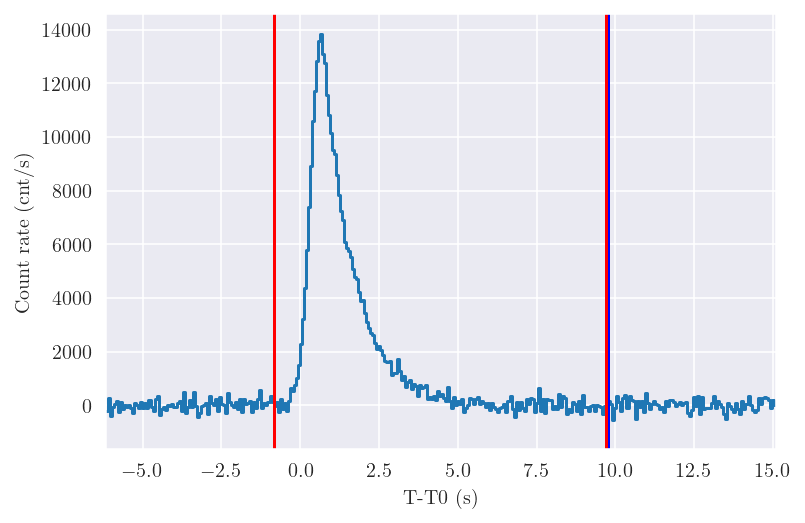

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 2
Total number of child pulses          : 2
---
Total number of pulses                : 4


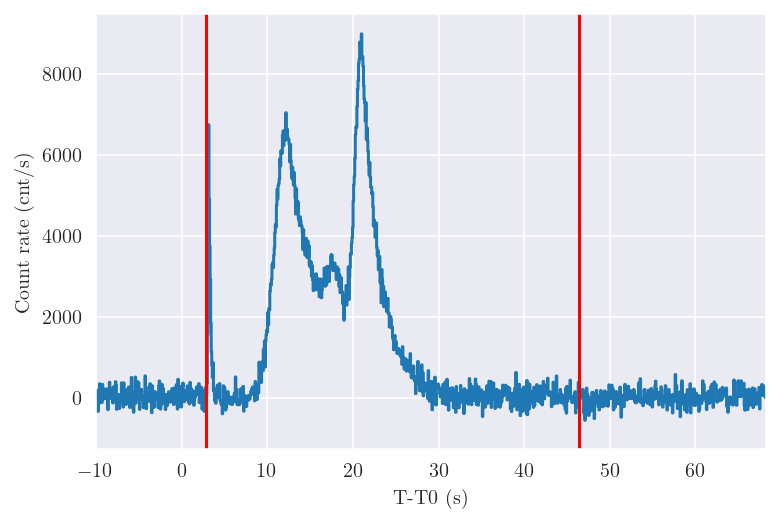

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


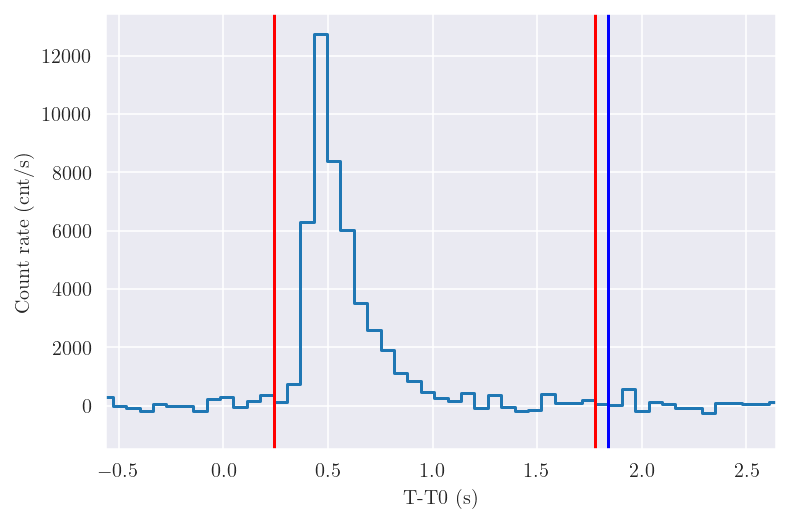

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 2
Total number of child pulses          : 16
---
Total number of pulses                : 18


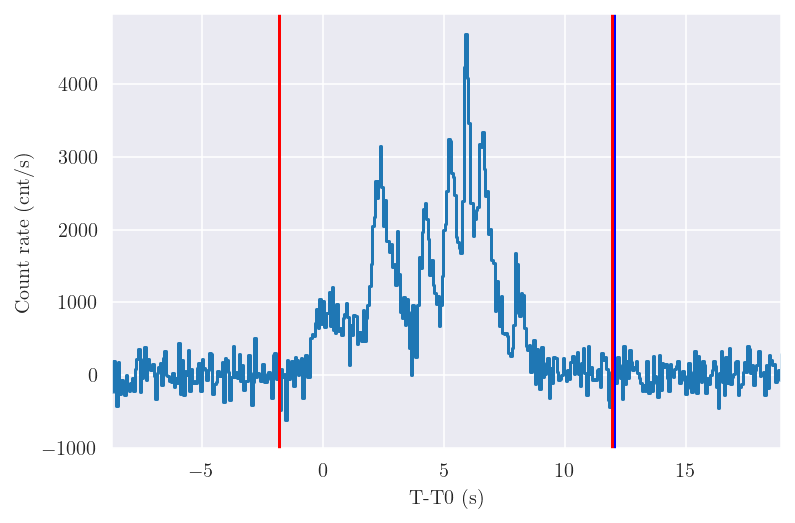

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 1
---
Total number of pulses                : 2


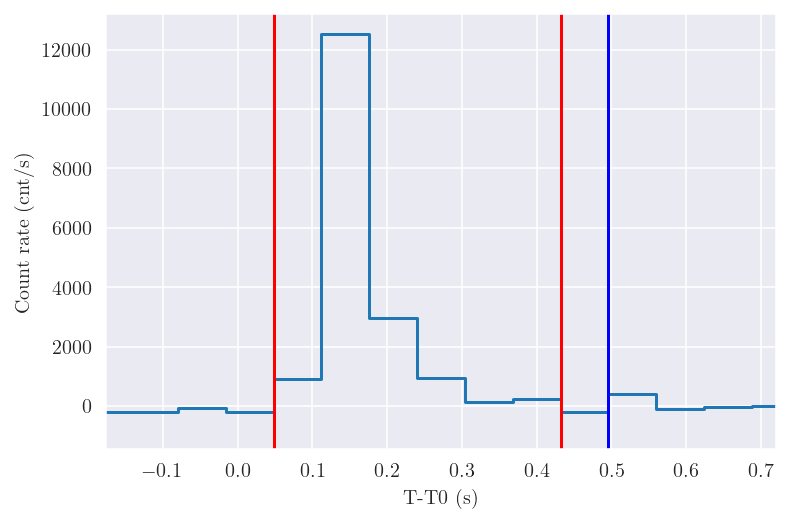

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 1
---
Total number of pulses                : 2


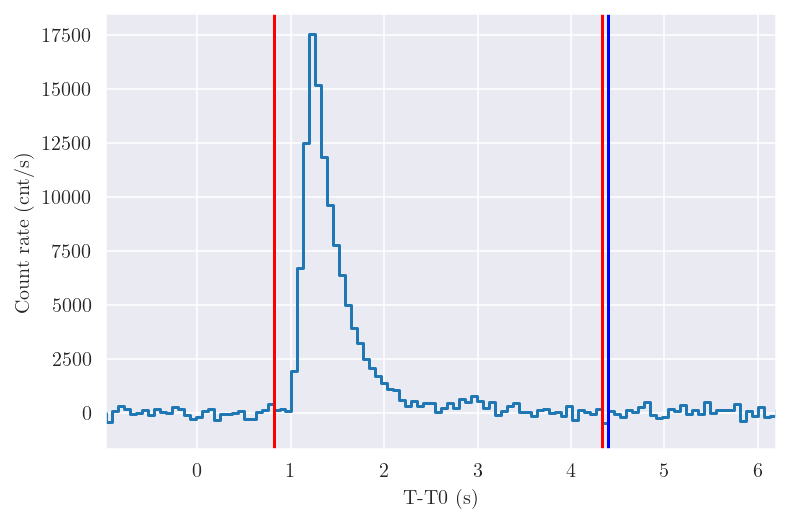

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 3
---
Total number of pulses                : 4


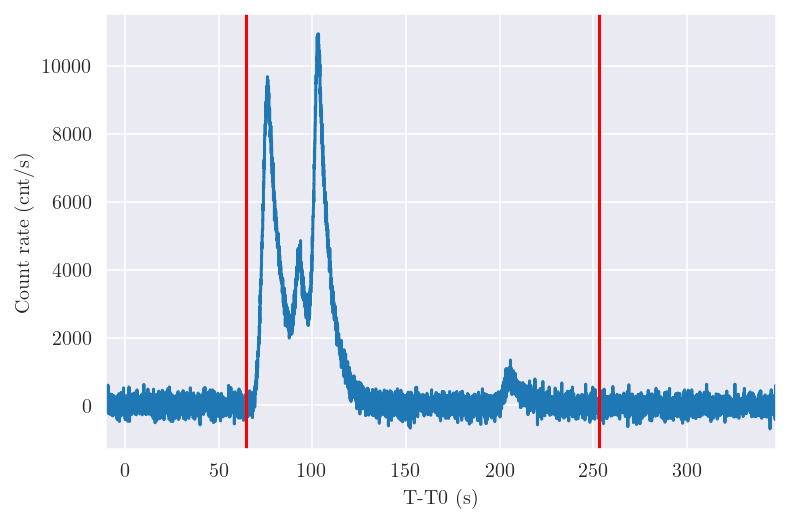

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


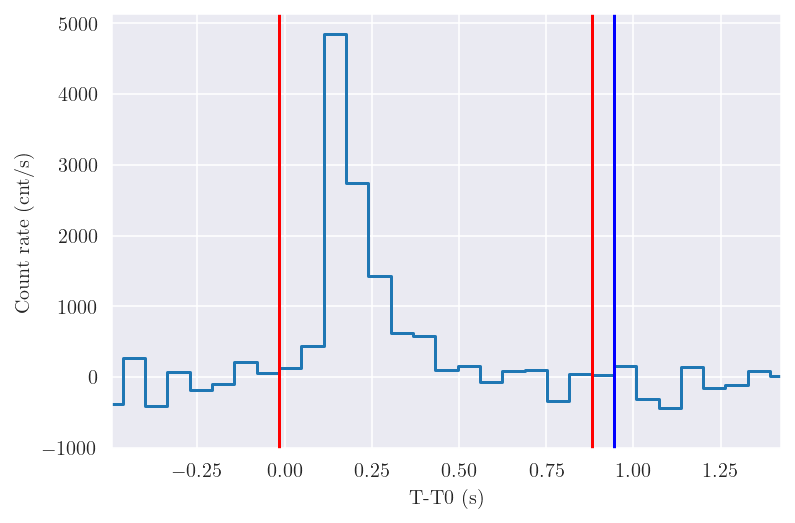

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 1261
---
Total number of pulses                : 1262


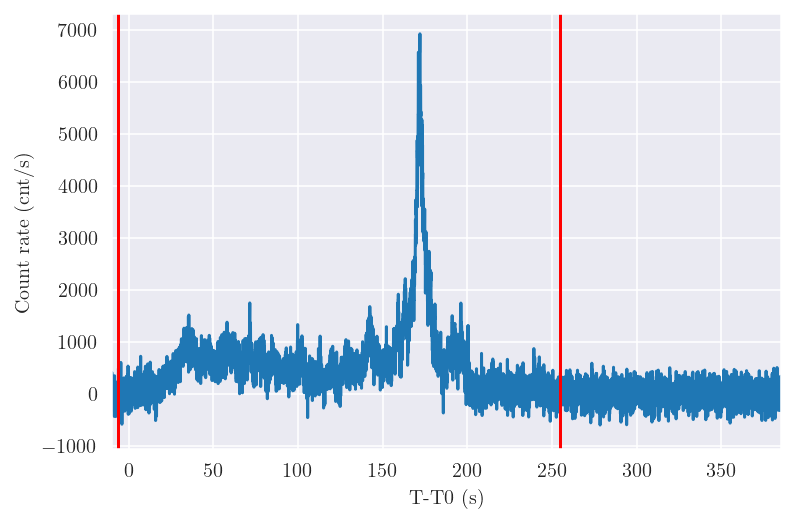

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


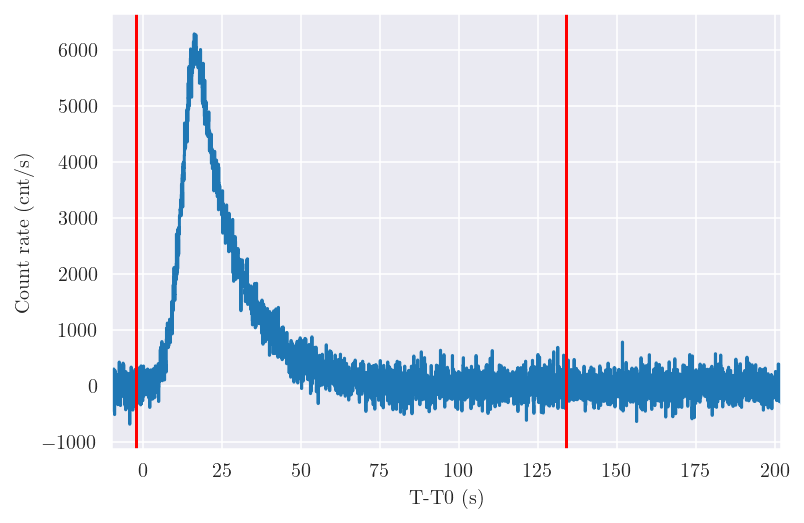

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 2
Total number of child pulses          : 0
---
Total number of pulses                : 2


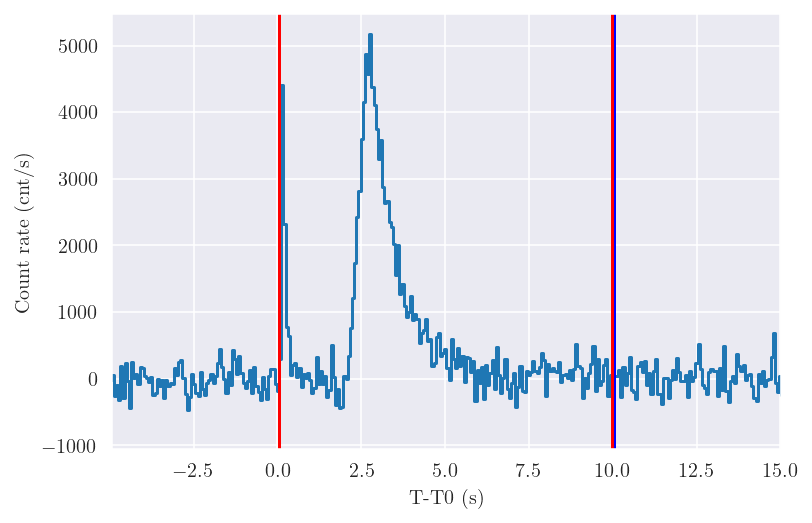

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 2
---
Total number of pulses                : 3


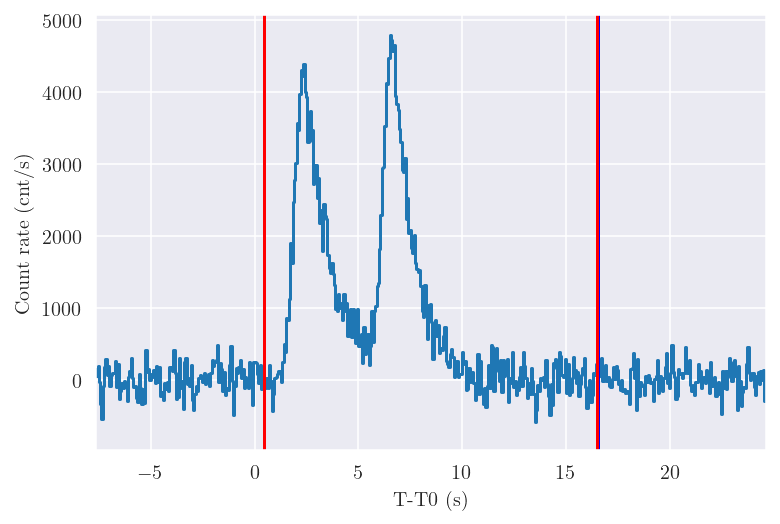

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 1
---
Total number of pulses                : 2


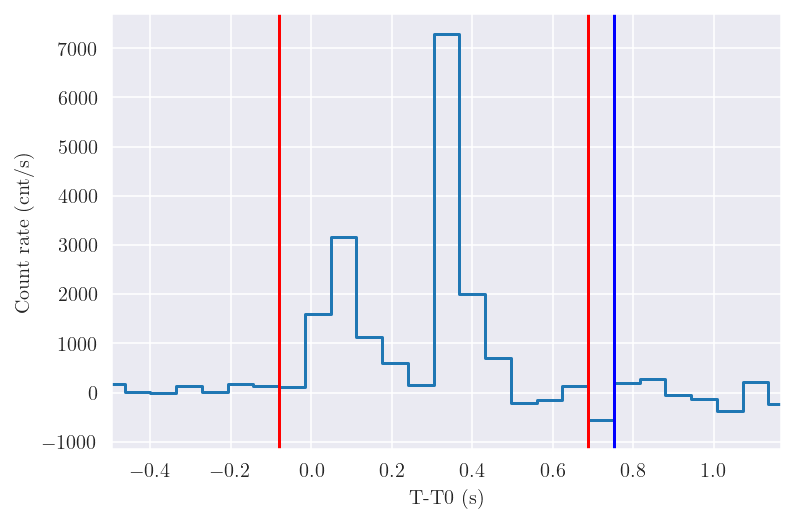

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 49
---
Total number of pulses                : 50


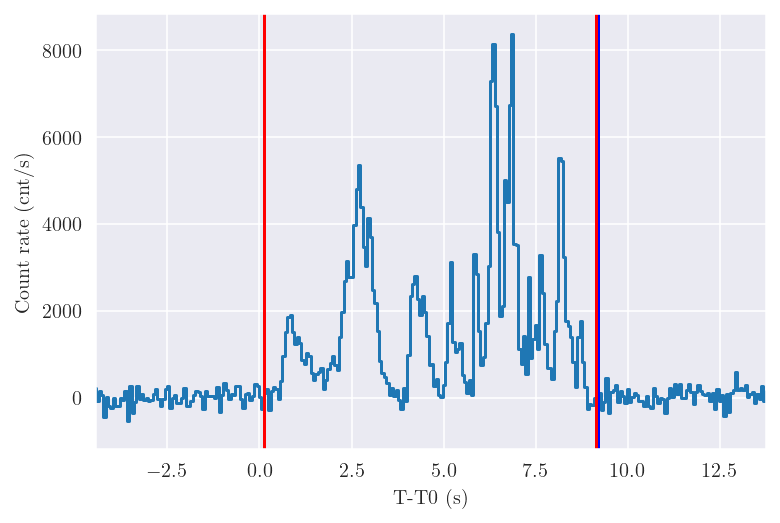

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


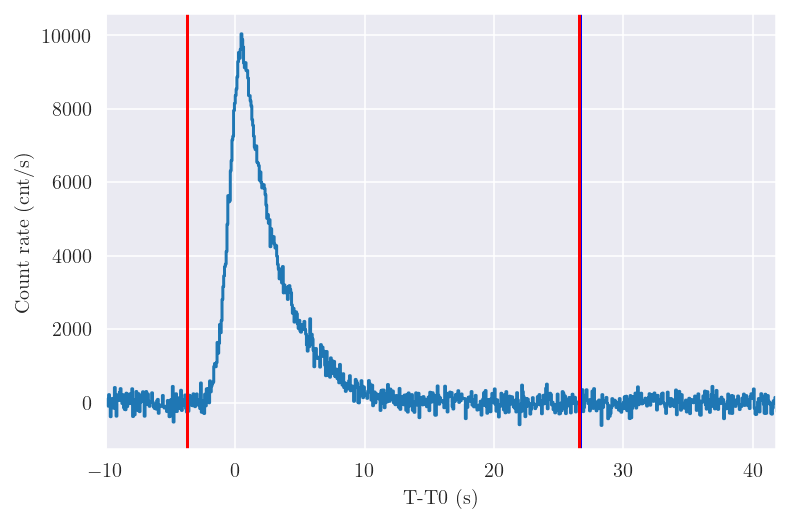

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


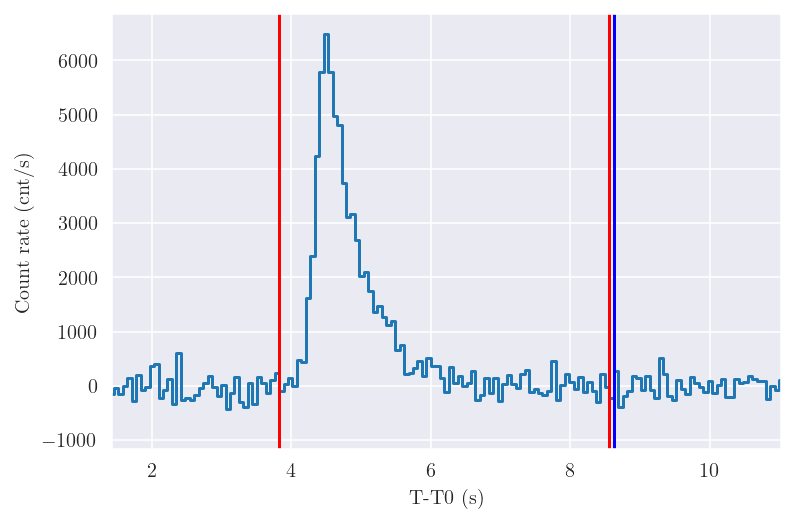

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


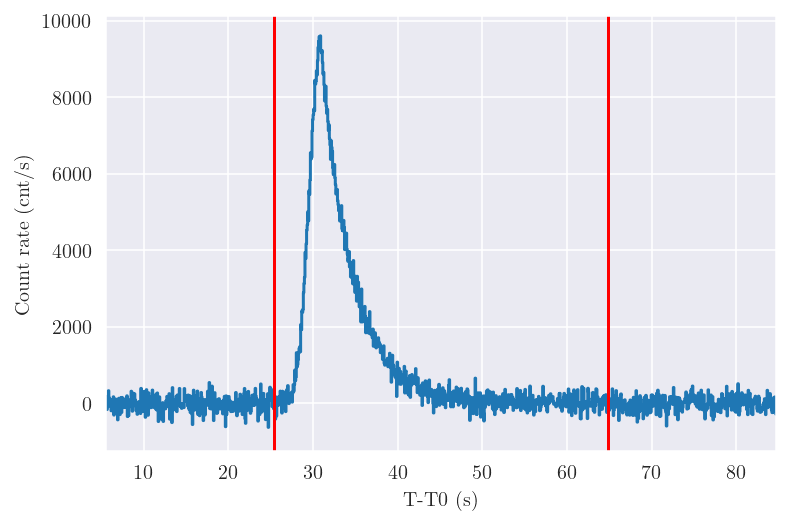

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 353
---
Total number of pulses                : 354


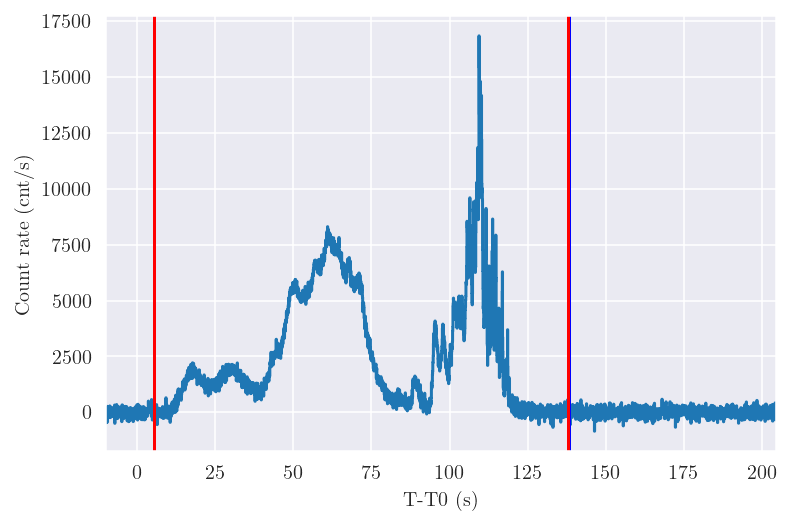

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1


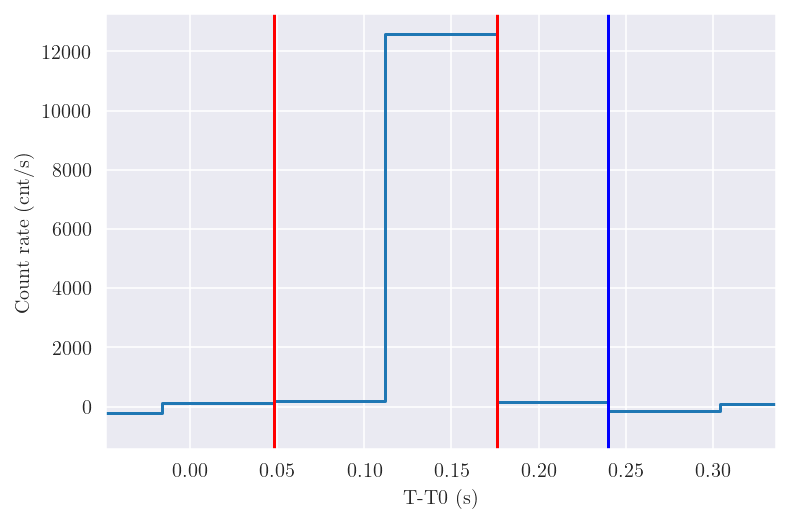

--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 8
---
Total number of pulses                : 9


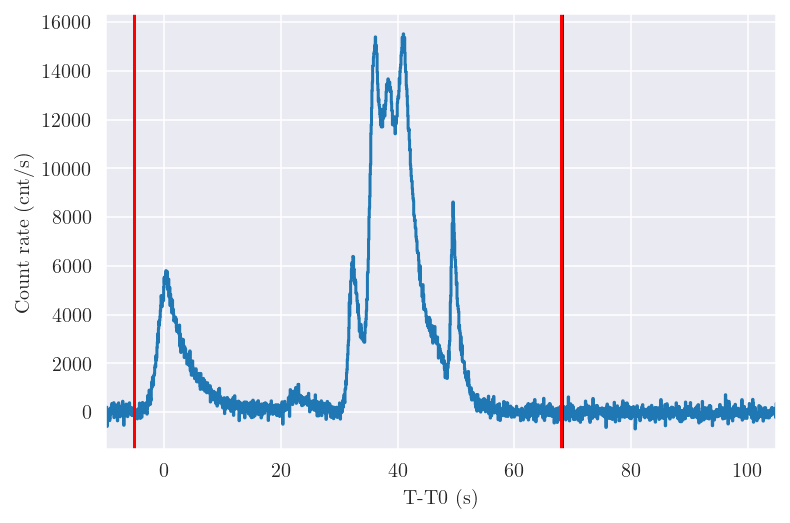

In [4]:
N_img=20
for i in range(N_img):
    lc = LC(mu=mu,
            mu0=mu0,
            alpha=alpha,
            delta1=delta1,
            delta2=delta2,
            tau_min=tau_min,
            tau_max=tau_max,
            res=res,
            n_cut=n_cut,
            with_bg=with_bg,
            verbose=False) 
    lc.generate_avalanche(seed=None)
    # print( len(lc._plot_lc) )
    lc.plot_lc(save=False,
               show_duration=True,
               rescale=True)
    del(lc)

The quantity `LC._plot_lc` contains the final light curve

Number of spontaneous (primary) pulses: 5
Total number of child pulses          : 77
---
Total number of pulses                : 82
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 5
Total number of child pulses          : 77
---
Total number of pulses                : 82
--------------------------------------------------------------------------


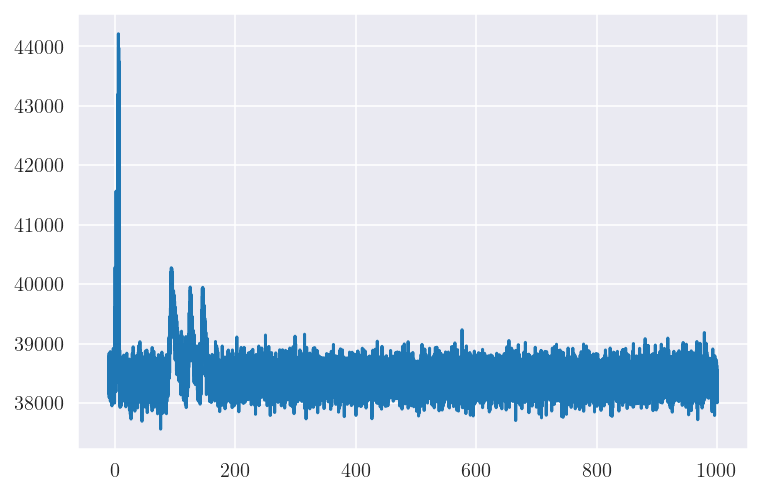

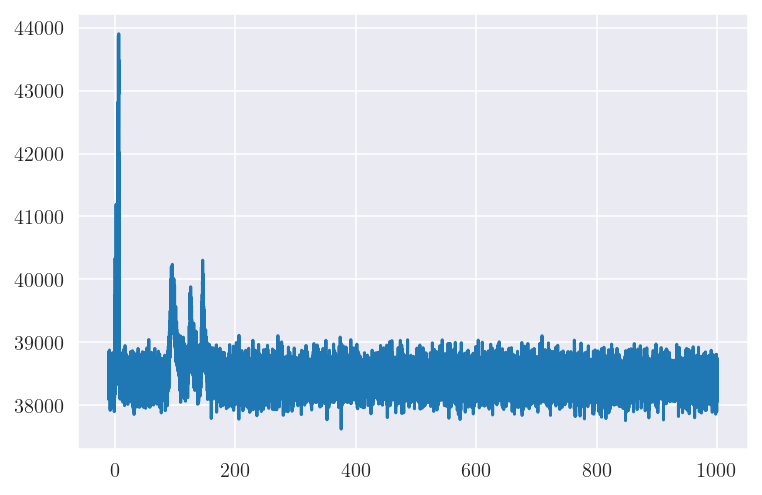

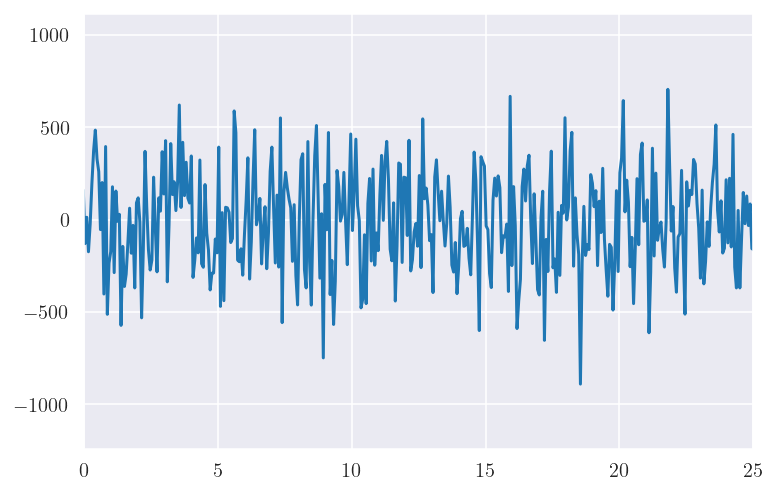

In [5]:
n_cut_1=10000
n_cut_2=100

lc1 = LC(mu=mu,
         mu0=mu0,
         alpha=alpha,
         delta1=delta1,
         delta2=delta2,
         tau_min=tau_min, 
         tau_max=tau_max,
         res=res,
         n_cut=n_cut_1)
lc2 = LC(mu=mu,
         mu0=mu0,
         alpha=alpha,
         delta1=delta1,
         delta2=delta2,
         tau_min=tau_min, 
         tau_max=tau_max,
         res=res,
         n_cut=n_cut_2)
            
par_1 = lc1.generate_avalanche(seed=SEED+3)
par_2 = lc2.generate_avalanche(seed=SEED+3)

plt.plot(lc1._times, lc1._plot_lc)
plt.show()

plt.plot(lc2._times, lc2._plot_lc)
plt.show()

plt.plot(lc1._times, lc1._plot_lc-lc2._plot_lc) 
# maybe the difference is not zero due to poissonian background;
# try to fix the seed also there and see if it disappears... 
plt.xlim(0, 25)
plt.show()

In [6]:
print(lc1._ampl)

0.5021942016886071


In [5]:
def export_lc(LC, idx, path='../simulations/'):
    """
    Export file with these columns: times, counts, err_counts, T90.
    Input:
    - LC: object that contains the light curve;
    - idx: number of the light curve;
    - path: path where to store the results of the simulations;
    """
    outfile  = path+'lc'+str(idx)+'.txt'
    savefile = open(outfile, 'w')
    times    = LC._times
    lc       = LC._plot_lc
    err_lc   = LC._err_lc
    T90      = LC._t90
    for i in range(len(times)):
        savefile.write('{0} {1} {2} {3}\n'.format(times[i], lc[i], err_lc[i], T90))
    savefile.close()

In [6]:
j=0
with_bg=False
N_grb=1000

while (j<N_grb):
    lc = LC(mu=mu,
            mu0=mu0,
            alpha=alpha,
            delta1=delta1,
            delta2=delta2,
            tau_min=tau_min, 
            tau_max=tau_max,
            res=res,
            n_cut=n_cut,
            with_bg=with_bg) 
    lc.generate_avalanche(seed=None)
    # save only lc with T90 > 2 sec
    if (lc._t90>2):
        export_lc(LC=lc, idx=j)
        j+=1
    del(lc)

Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 3
Total number of child pulses          : 42
---
Total number of pulses                : 45
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 0
---
Total number of pulses                : 1
--------------------------------------------------------------------------
Number of spontaneous (primary) pulses: 1
Total number of child pulses          : 106
---
Total number of pulses                : 107
--------------------------------------------

### Export file with data

In [7]:
lc.hdf5_lc_generation(outfile="./test.h5", overwrite=True, seed=17)

In [9]:
filename = "./test.h5"

with h5py.File(filename, "r") as hf:
    data = np.array(hf.get('GRB_PARAMETERS/GRB_1')[:])
    hf['GRB_PARAMETERS/GRB_1'].attrs.keys()
    n_pulses  = hf['GRB_PARAMETERS/GRB_1'].attrs['N_PULSES']
    peak_flux = hf['GRB_PARAMETERS/GRB_1'].attrs['PEAK_VALUE']
    
data.shape

(8246, 4)

In [11]:
hf

<Closed HDF5 file>

### Let's open a yaml-file with avalanches and plot the T90 distribution for the sample

In [2]:
with open("./avalanche_parameters.yml", 'r') as f:
        loaded_data = yaml.safe_load(f)

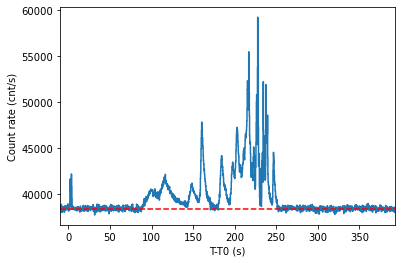

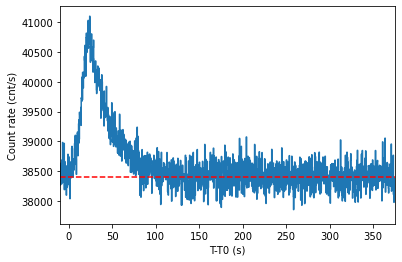

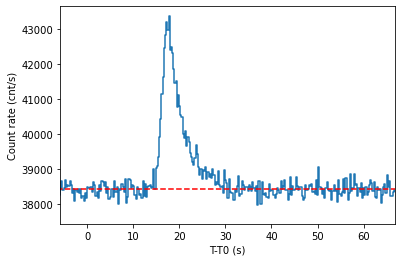

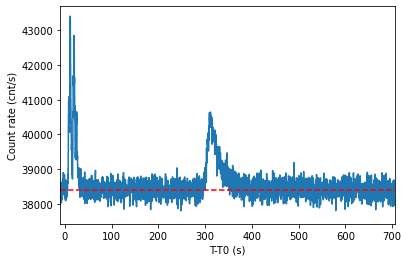

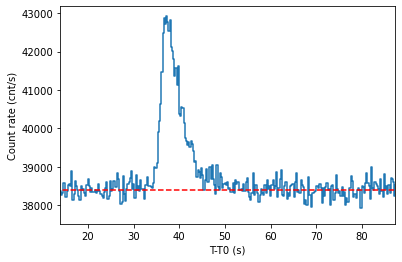

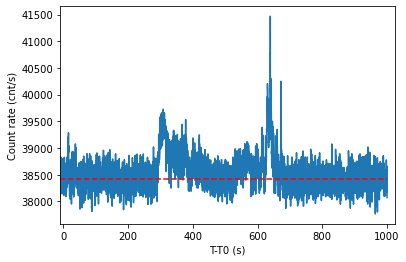

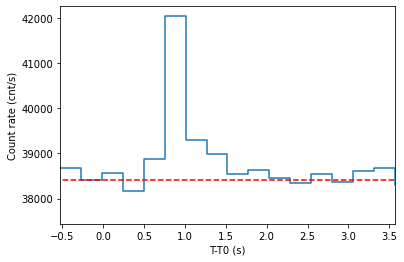

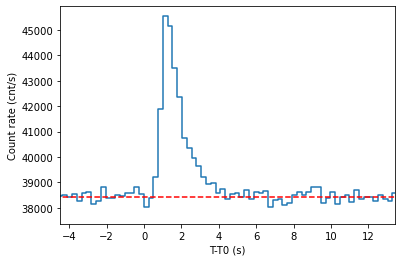

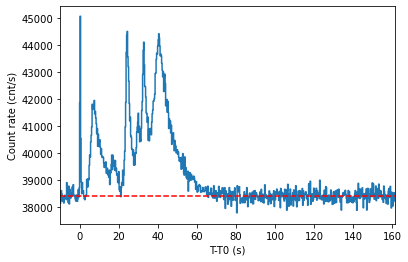

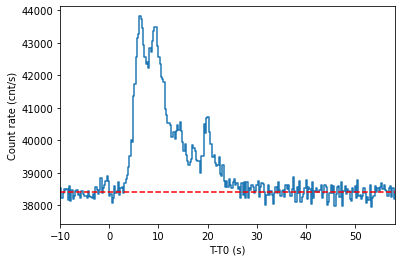

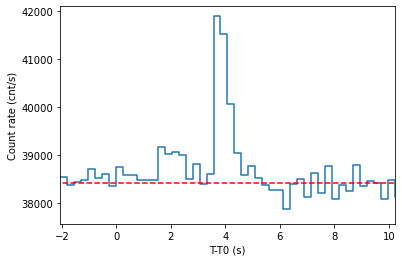

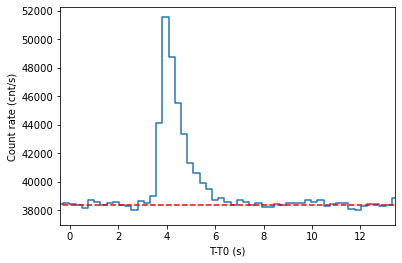

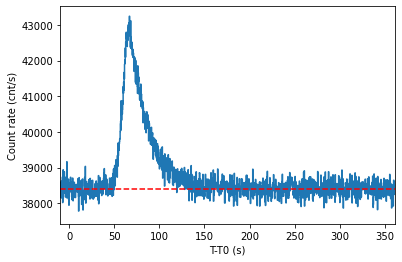

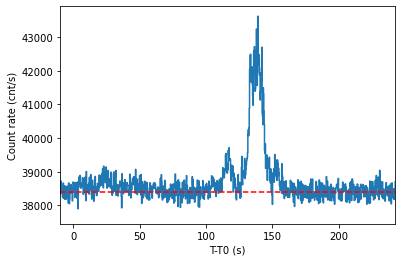

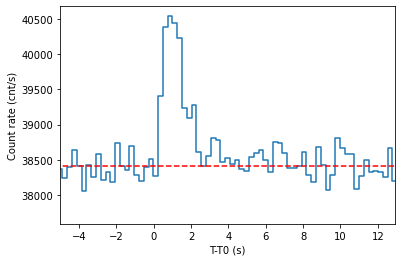

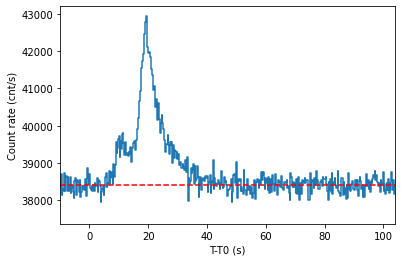

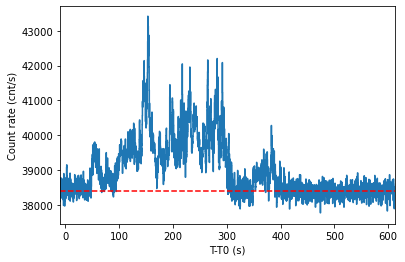

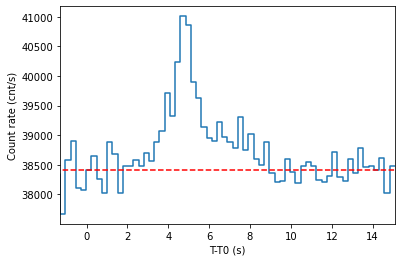

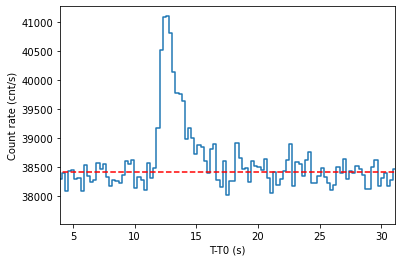

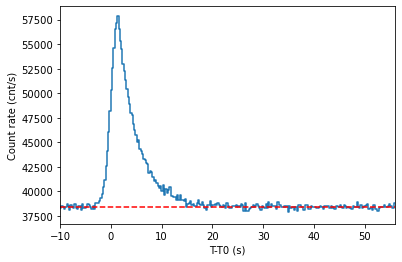

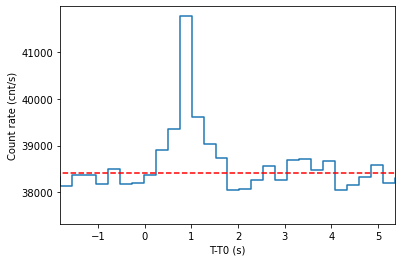

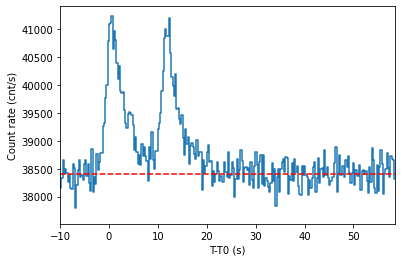

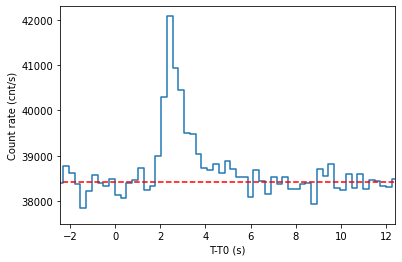

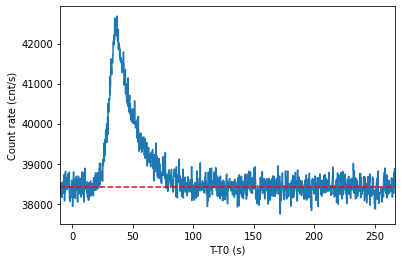

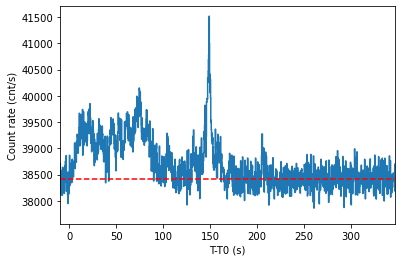

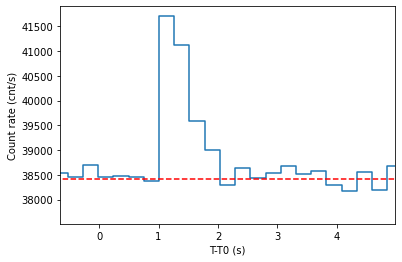

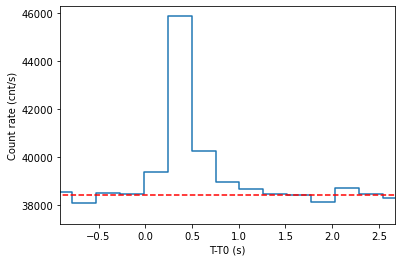

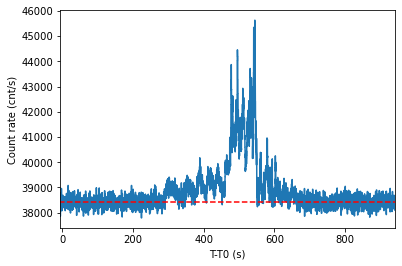

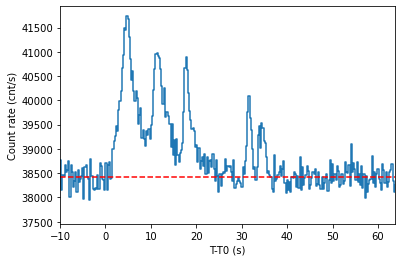

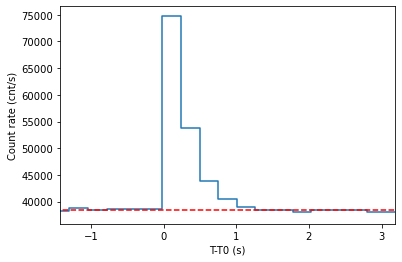

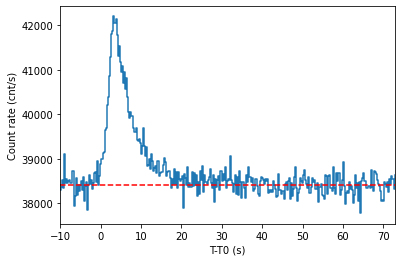

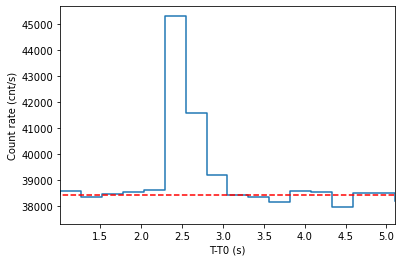

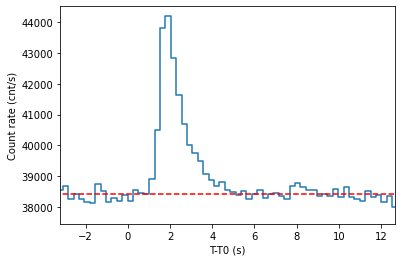

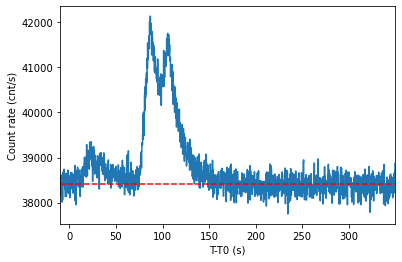

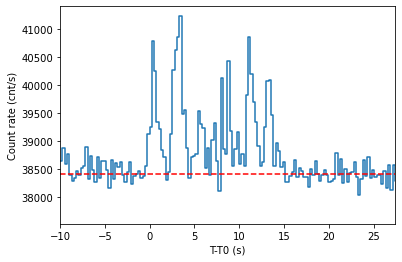

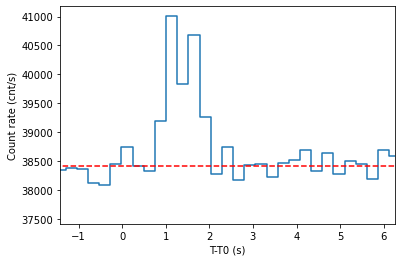

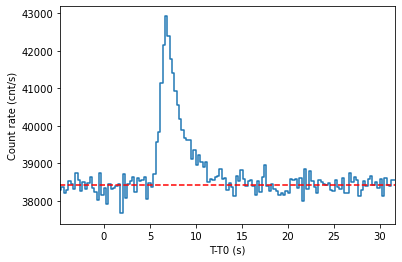

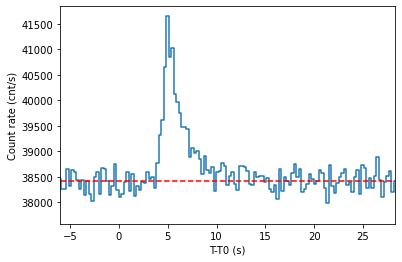

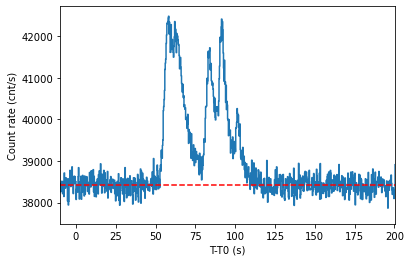

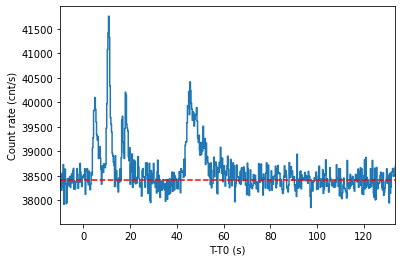

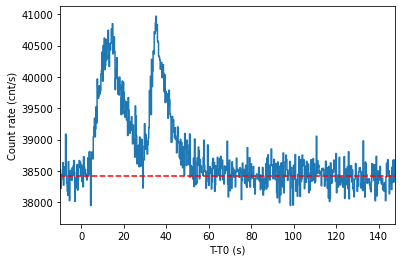

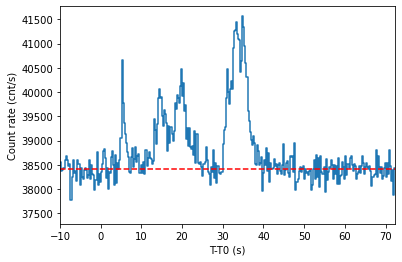

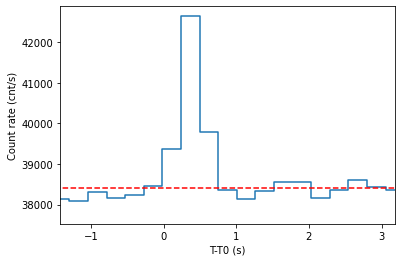

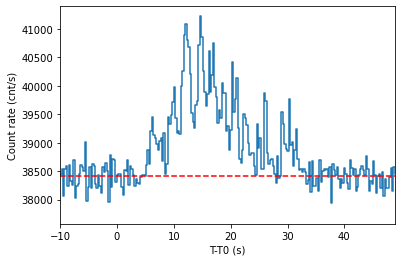

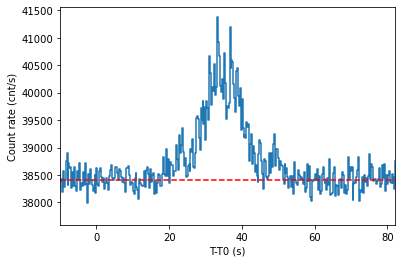

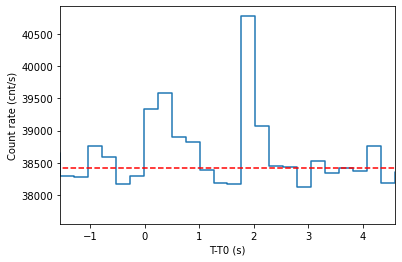

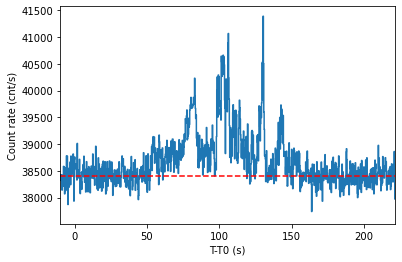

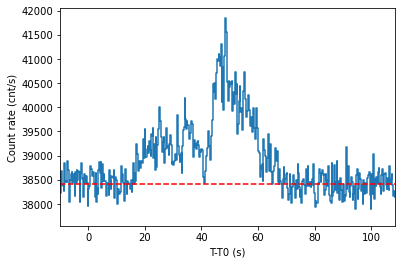

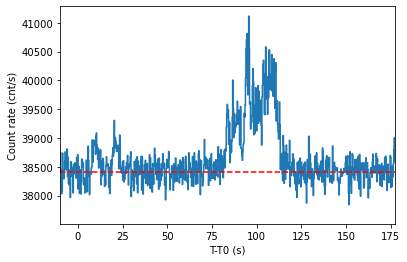

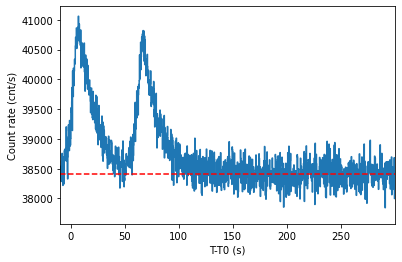

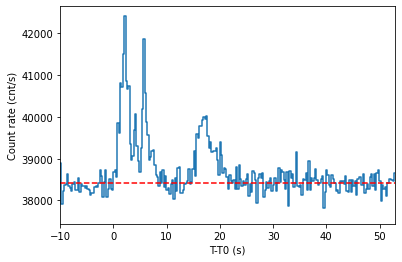

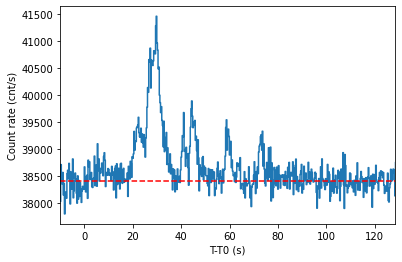

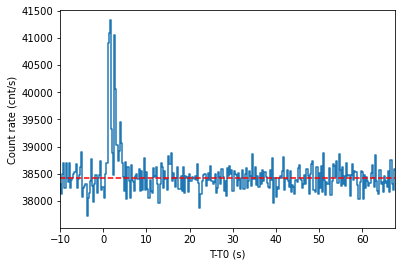

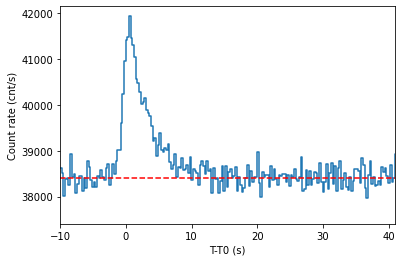

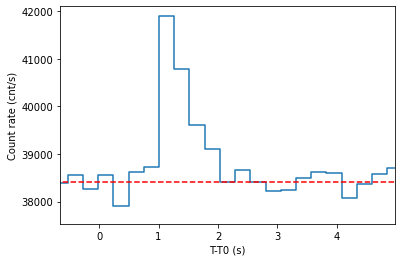

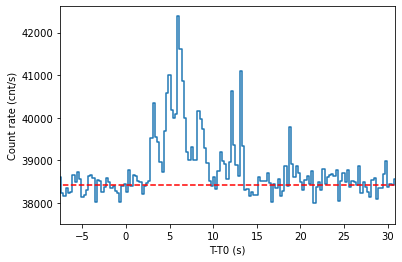

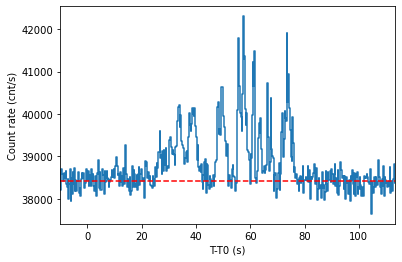

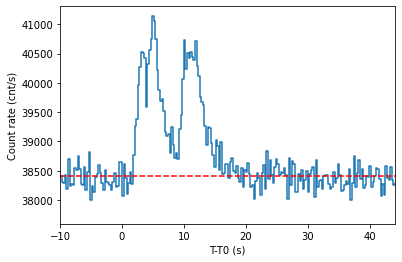

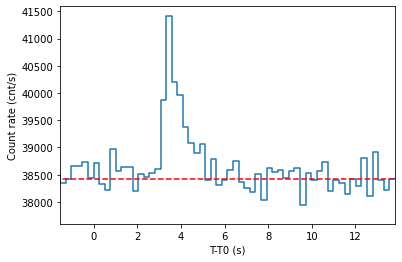

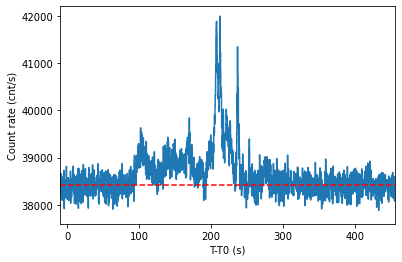

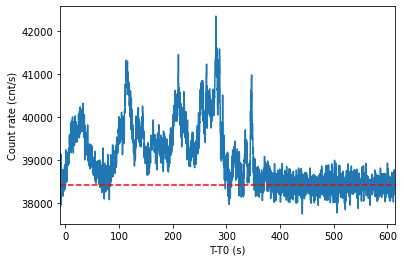

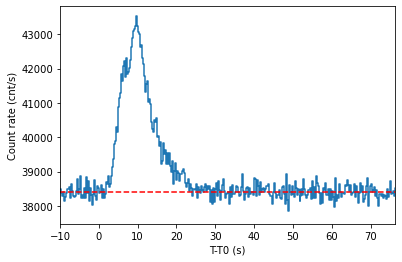

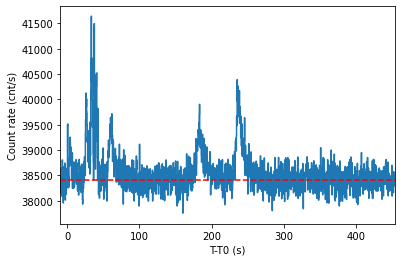

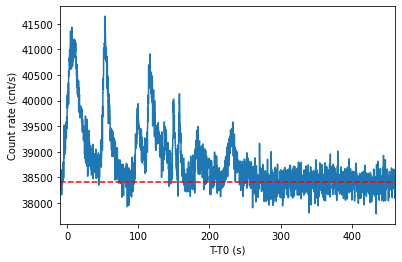

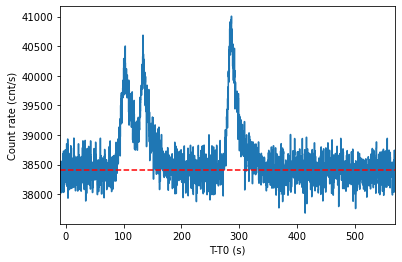

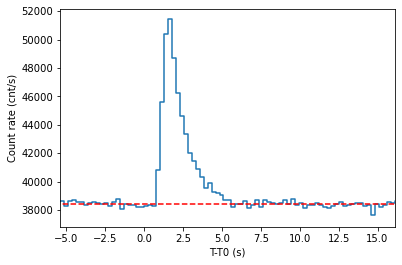

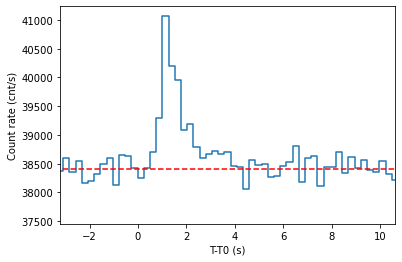

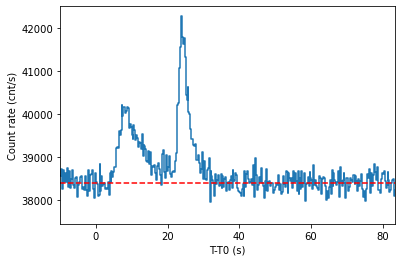

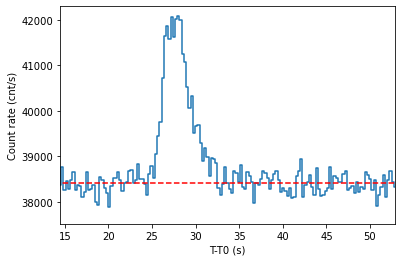

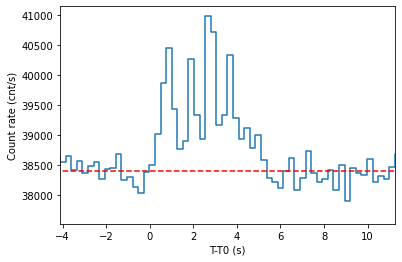

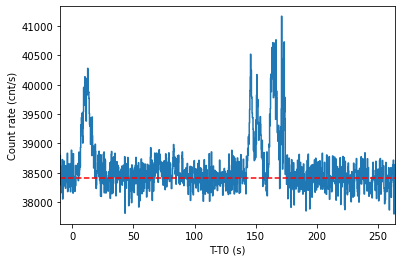

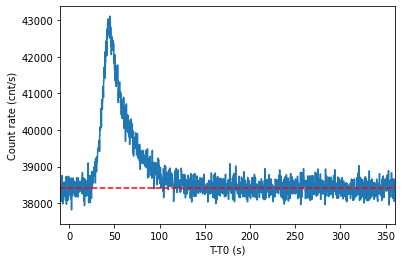

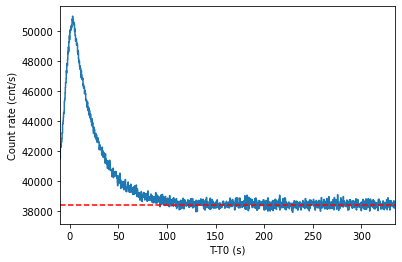

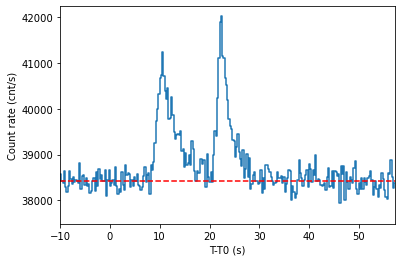

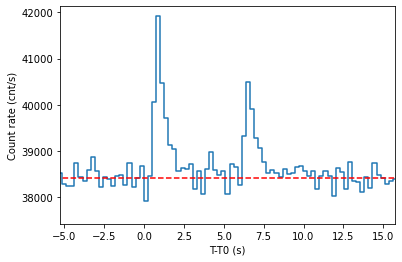

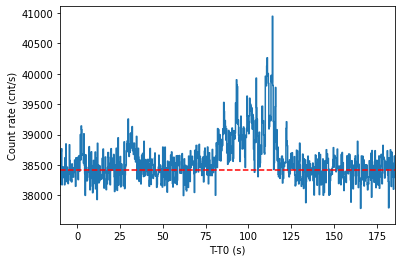

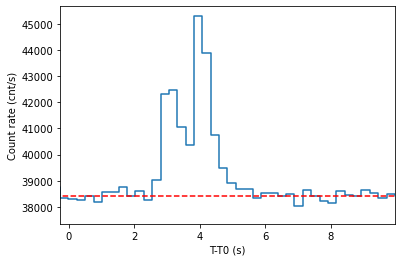

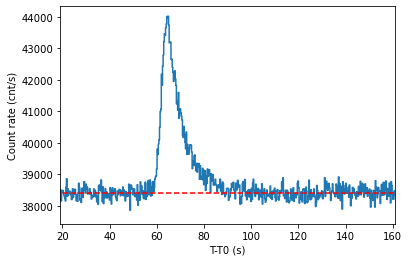

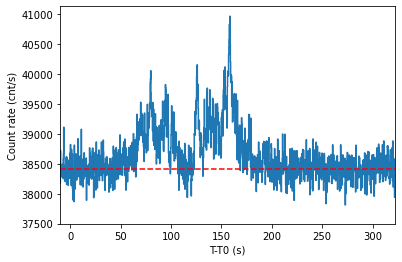

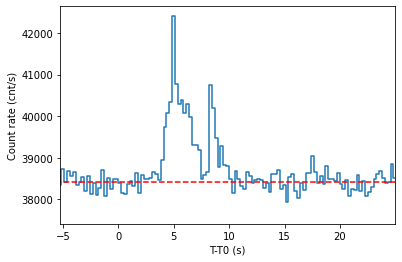

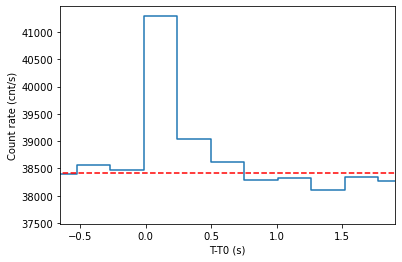

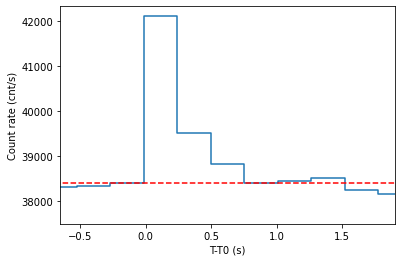

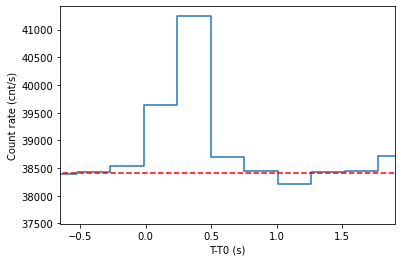

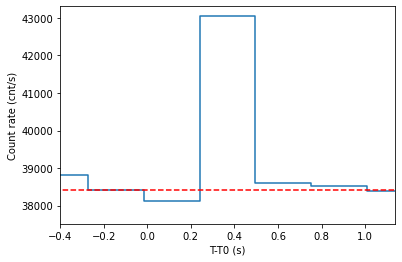

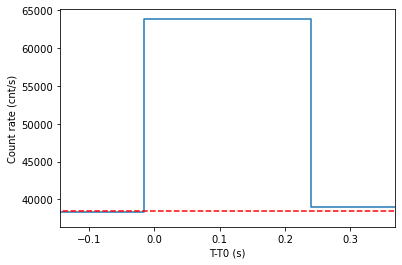

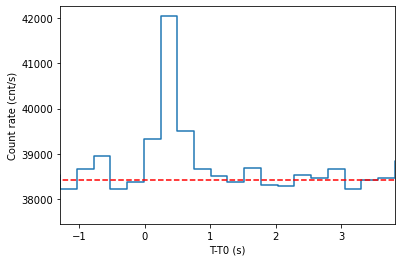

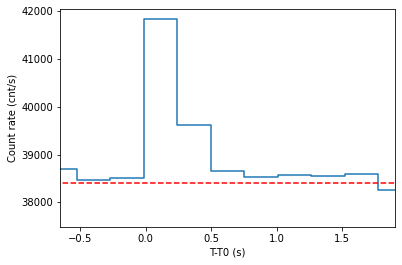

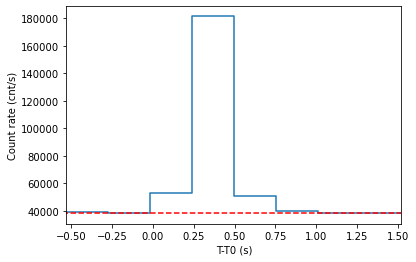

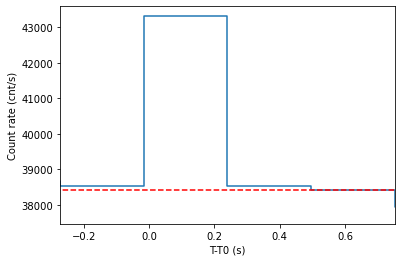

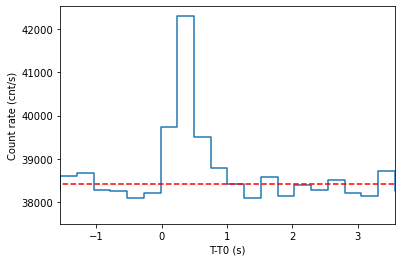

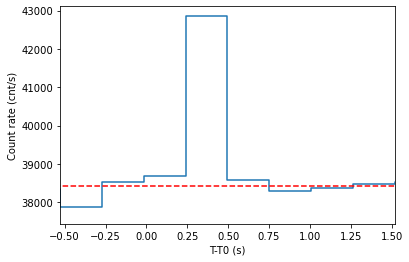

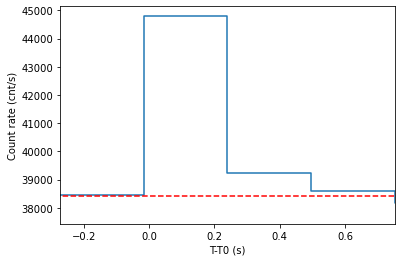

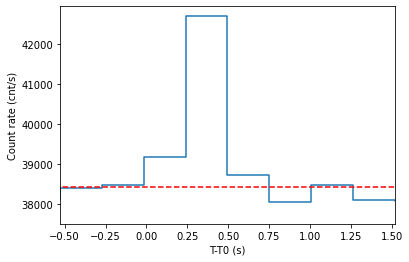

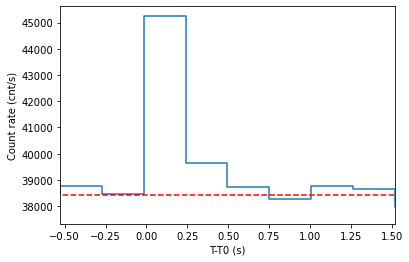

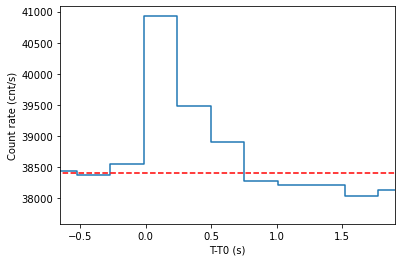

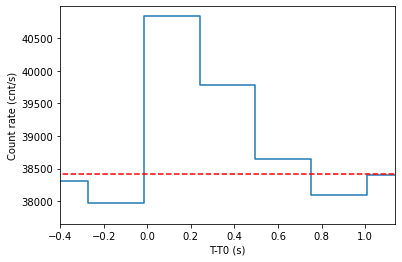

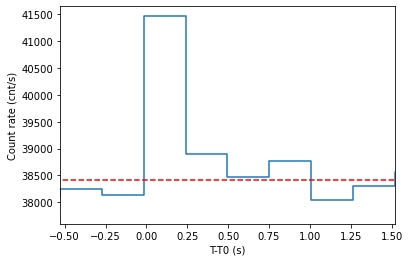

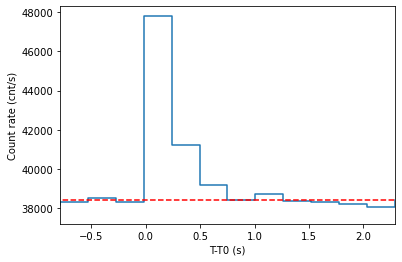

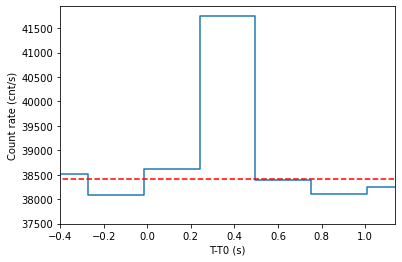

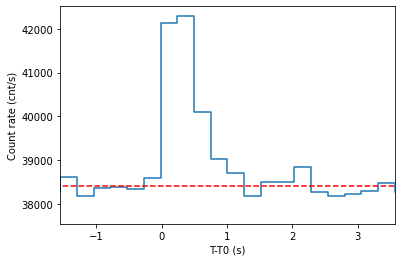

In [5]:
T90 = list()

for name in loaded_data:
    par_list=list(name.values())[0]
    lc=Restored_LC(par_list)
    lc._with_bg=True
    lc.plot_lc()
    T90.append(float(lc.T90[0]))

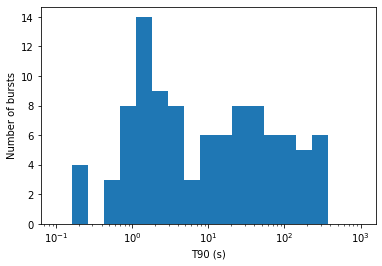

In [4]:
plt.hist(T90, bins=np.geomspace(0.1,1000,20))
plt.xlabel("T90 (s)")
plt.ylabel("Number of bursts")
plt.xscale('log')
plt.show()